In [38]:
import cv2
import math
import numpy as np
import sys
import os
import itertools
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from scipy import ndimage
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
#from keras.engine.topology import Layer
from tensorflow.python.keras.layers import Layer
#import tensorflow.python.keras.engine import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
#path_weights='/content/drive/My Drive/Colab Notebooks/weights7/'
#path_weights = 'E:/weights'
path_weights = 'E:/nancy/svm'
dir_list = os.listdir(path_weights) 
print(dir_list)

['CM.png', 'history1_3epoch.pickle', 'history_3epoch.pickle', 'model1_3epoch.h5py', 'model1_history1_log.csv', 'model_3epoch.h5py', 'model_history1_log.csv', 'model_history_log.csv', 'signet-001.h5py', 'signet1-001.h5py', 'signet1-002.h5py', 'signet1-003.h5py', 'signet1-004.h5py', 'signet1-005.h5py', 'signet1-006.h5py', 'signet1-007.h5py', 'signet1-008.h5py', 'signet1-009.h5py', 'signet1-010.h5py', 'signet111-001.h5py', 'y_history_3epoch.pickle', 'y_pred.pickle']


In [3]:
path_dataset = "/content/drive/MyDrive/final dataset1"
path_dataset = "E:/Cnn dataset"
dir_list = next(os.walk(path_dataset))[1]
dir_list.sort()
dir_list

['099',
 '1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '124',
 '126',
 '127',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '148',
 '149',
 '15',
 '150',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '16',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '18',
 '180',
 '181',
 '182',
 '183',
 '184',
 '185',
 '186',
 '187',
 '188',
 '189',
 '19',
 '190',
 '191',
 '192',
 '193',
 '194',
 '195',
 '196',
 '197',
 '198',
 '199',
 '2',
 '20',
 '200',
 '201',
 '202',
 '203',
 '204',
 '205',
 '206',
 '207',
 '208',
 '209',
 '21',
 '210',
 '211',
 '212',
 '213',
 '214',
 '215',
 '216',
 '217',
 '218',
 '219',

PREPROCESSING

In [4]:
def preprocess(image):
    clean = remove_background(image)
    roi = extract_signature(clean)
    th,res= cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # r = ndimage.rotate(res, -(90-math.degrees(math.atan(res.shape[1]/res.shape[0]))))
    # angle = 90-math.degrees(math.atan(res.shape[1]/res.shape[0]))
    # if angle > 20:
    #     res = rotate_image(res, -(angle if angle>20 else 0))
   
    return res

def rotate_image(image, angle):
  rot_mat = cv2.getRotationMatrix2D((image.shape[0]/2+40,image.shape[1]/2+40), angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, (int(math.sqrt(image.shape[0]*image.shape[0]+image.shape[1]*image.shape[1])),int(image.shape[1])), flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result



def extract_signature(image):
    result = image.copy()
    img = image.copy()
    ret, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    # opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    cnts,hi = cv2.findContours(closing.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boxes = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        boxes.append([x,y, x+w,y+h])
    
    boxes = np.asarray(boxes)
    left = np.min(boxes[:,0])
    top = np.min(boxes[:,1])
    right = np.max(boxes[:,2])
    bottom = np.max(boxes[:,3])
    
    result[closing==0] = (255)
    ROI = result[top:bottom, left:right].copy()
    cv2.rectangle(result, (left,top), (right,bottom), (36, 255, 12), 2)
    
    # cv2.imshow('result', result)
    # cv2.imshow('ROI', ROI)
    # cv2.imshow('Mask', mask)
    # cv2.imshow('closing',closing)

    cv2.waitKey()
    
    return ROI


def remove_background(img):
        """ Remove noise using OTSU's method.

        :param img: The image to be processed
        :return: The normalized image
        """
        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
    
        threshold, _ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


In [5]:
from sklearn.preprocessing import LabelEncoder 
from keras.models import model_from_json 

In [ ]:
def remove_background(img):
    # Remove noise using gaussian filter and OTSU's method.


    # Gaussian filter for removing small components
    blur_radius = 2
    blurred_image = ndimage.gaussian_filter(img, blur_radius)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    th, bin_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return th, bin_image

In [ ]:
def extract_signature(img, bin_image,img_w,img_h):
    # Find the center of mass
    x, y = np.where(bin_image == 0)
    x_center = int(x.mean() - x.min())
    y_center = int(y.mean() - y.min())

    # Crop the image with a tight box
    cropped = img[x.min(): x.max(), y.min(): y.max()]
    # cv2.imshow('cropped', cropped)
    
    # Center the image
    img_x, img_y = cropped.shape

    x_start = img_w // 2 - x_center
    y_start = img_h // 2 - y_center
    extra_x = (x_start + img_x) - img_w
    if extra_x > 0:
        x_start -= extra_x
    if x_start < 0:
        x_start = 0
    extra_y = (y_start + img_y) - img_h
    if extra_y > 0:
        y_start -= extra_y
    if y_start < 0:
        y_start = 0
        
    
    return x_start, y_start, img_x, img_y, cropped

In [6]:
def resize_image(image, new_size,):
    height, width = new_size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(image.shape[1]) / width
    height_ratio = float(image.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(image.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(image.shape[0] / width_ratio))

    # Resize the image
    image = cv2.resize(image.astype(np.float32), (resize_width,resize_height), interpolation=cv2.INTER_LINEAR)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return image[:, start:start+width]
    else:
        start = int(round((resize_height-height)/2.0))
        return image[start:start+height, :]
def crop_center(img, input_shape):
    img_shape = img.shape
    start_y = (img_shape[0] - input_shape[0]) // 2
    start_x = (img_shape[1] - input_shape[1]) // 2
    cropped = img[start_y: start_y + input_shape[0], start_x:start_x + input_shape[1]]
    return cropped

In [7]:
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path_dataset+ '/' +directory)
    images.sort()
    images = [path_dataset+'/' +directory+'/'+x for x in images]
    forg_groups.append(images[:15])
    orig_groups.append(images[15:])

In [8]:
# prints 1 1 if length of each group is same
def sanity_check():
    orig_lengths = [len(x) for x in orig_groups]
    forg_lengths = [len(x) for x in forg_groups]
    f_original=0
    for i in range(0,len(orig_lengths)):
        for j in range(i+1,len(orig_lengths)):
                   if orig_lengths[i]==orig_lengths[j]:
                       f_original=1
    f_forged=0
    for i in range(0,len(forg_lengths)):
        for j in range(i+1,len(forg_lengths)):
                   if forg_lengths[i]==forg_lengths[j]:
                       f_forged=1
    print(f_original)
    print(f_forged)

In [9]:
sanity_check()

1
1


In [11]:
orig_train, orig_val, orig_test = orig_groups[:400], orig_groups[400:486], orig_groups[486:]
forg_train, forg_val, forg_test = forg_groups[:400], forg_groups[400:486], forg_groups[486:]

In [12]:
img_h, img_w = 155, 220

In [13]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 12 genuine signatures in a group, hence we have 
        # 12 choose 2 = 66 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 6 randomly sampled Forged signatures of the same person.

        
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 6)))) #6 for 6 samples random
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            # img1 = preprocess(img1)
            # img2 = preprocess(img2)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [14]:
# from sklearn.metrics.pairwise import cosine_similarity
# cosine_similarity([[1, 0, -1]], [[-1,-1, 0]])

def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [15]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [16]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [17]:
def network_architecture(input_shape):

    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        kernel_initializer='glorot_uniform', data_format='channels_last'))

    model.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    model.add(MaxPooling2D((3,3), strides=(2, 2)))    
    model.add(ZeroPadding2D((2, 2), data_format='channels_last'))
    
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    model.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    model.add(MaxPooling2D((3,3), strides=(2, 2)))
    model.add(Dropout(0.3))# added extra
    model.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    model.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))    
    model.add(MaxPooling2D((3,3), strides=(2, 2)))
    model.add(Dropout(0.3))# added extra
    
    model.add(Flatten(name='flatten'))

    model.add(Dense(1024, bias_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, bias_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu
    
    return model

In [18]:
input_shape=(img_h, img_w, 1)

In [19]:
# network definition
base_network = network_architecture(input_shape)
input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)
# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b], distance)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          6461084     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

In [21]:
base_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 37, 53, 96)        11712     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 37, 53, 96)        148       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 26, 96)        0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 22, 30, 96)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 18, 26, 256)       614656    
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 18, 26, 256)       72        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 12, 256)        0

In [23]:
batch_sz = 100
num_train_samples = 105*len(orig_train) + 120*len(orig_train)
num_val_samples = num_test_samples = 105*len(orig_val) + 120*len(orig_val)
num_train_samples, num_val_samples, num_test_samples

(90000, 19350, 19350)

In [28]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
#adam = Adam(learning_rate=1e-4)
#model.compile(loss=contrastive_loss, optimizer=rms, metrics=['acc'])
adam = Adam(lr=1e-6)
model.compile(loss = "binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [32]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('E:/weights/signet-Engsig61-{epoch:03d}.h5py', monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=True,mode='min')
] #260-{epoch:03d}

In [39]:
callbacks = [
  EarlyStopping(patience=15, restore_best_weights=True),
  CSVLogger(r"E:/nancy/svm/model_history_log.csv", append=True),
  # ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001),
  ModelCheckpoint(r"E:/nancy/svm/signet-{epoch:003d}.h5py"),
  # ModelCheckpoint(r"/content/drive/MyDrive/graduation project (ML)/model_5/signet_Best_Model.h5", save_best_only=True)
]

In [41]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 5,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/5
900/900 [==============================] - 2206s 2s/step - loss: 11.3522 - accuracy: 0.2556 - val_loss: 1.1951 - val_accuracy: 0.2772
INFO:tensorflow:Assets written to: E:/nancy/svm\signet-001.h5py\assets
Epoch 2/5
165/900 [====>.........................] - ETA: 28:04 - loss: 11.3547 - accuracy: 0.2554

KeyboardInterrupt: 

In [43]:
tpr_list = []
tnr_list = []
threshold_list = []

def compute_accuracy_roc(predictions, labels):
    '''Compute accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       

        if (acc > max_acc):
            max_acc, best_thresh = acc, d
        tpr_list.append(tpr)
        tnr_list.append(tnr)
        threshold_list.append(best_thresh)
           
    return max_acc, best_thresh
    

In [46]:
model.load_weights("E:/nancy/svm/signet-001.h5py")
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], [] #tr_y have label
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])
acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
acc, threshold

(0.673143968408357, 0.5850860440731052)

In [47]:
pred_binary = [1 if x<0.012809 else 0 for x in pred]

In [48]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(pred_binary, tr_y,average='macro')
precision,recall,fscore

C:\Users\Angana Das CBS\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5, 0.3749095607235142, 0.4285123600815145)

Text(0.5, 1.0, 'True Positive Rate')

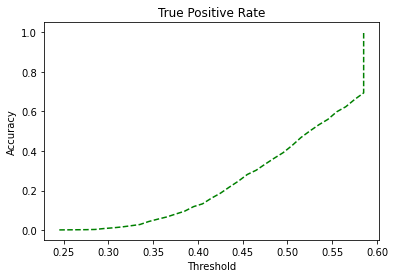

In [51]:
plt.plot(threshold_list,tpr_list,'g--')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('True Positive Rate')

#from google.colab import files
#plt.savefig("TPR.png")
#files.download("TPR.png") 

Text(0.5, 1.0, 'True Negative Rate')

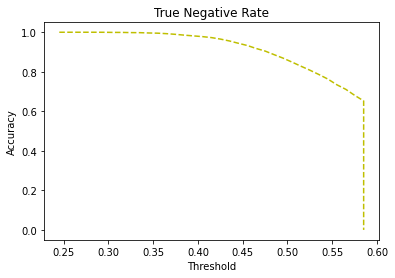

In [53]:
plt.plot(threshold_list,tnr_list,'y--')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('True Negative Rate')

#from google.colab import files
#plt.savefig("TNR.png")
#files.download("TNR.png")

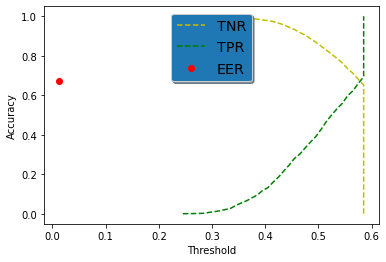

In [55]:
fig, ax = plt.subplots()

ax.plot(threshold_list, tnr_list, 'y--', label='TNR')
ax.plot(threshold_list, tpr_list, 'g--', label='TPR')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.plot(0.0128,acc,'ro', label='EER') 

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

#from google.colab import files
#plt.savefig("EER.png")
#files.download("EER.png") 

In [56]:
def verify(img1, img2):
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    #print(img1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

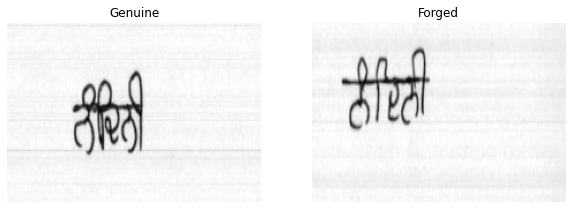

Difference Score =  0.7111784
Its a Forged Signature


In [57]:
img1 = cv2.imread('E:/Cnn dataset/3/3_FORG_11.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('E:/Cnn dataset/3/3_ORG_07.jpg',cv2.IMREAD_GRAYSCALE)


verify(img1,img2)

In [60]:
from sklearn.metrics import classification_report, confusion_matrix

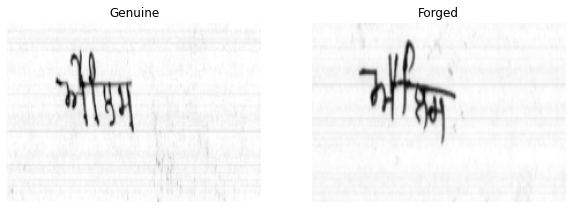

Difference Score =  0.47096375
Its a Genuine Signature


In [63]:
img1 = cv2.imread('E:/Cnn dataset/12/12_ORG_03.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('E:/Cnn dataset/12/12_FORG_05.jpg',cv2.IMREAD_GRAYSCALE)


verify(img1,img2)